# LightGBM: ARI

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *
from src.plot_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

# Load best model

In [4]:
params = get_best_parameters('ari-lightgbm', 'lightgbm', 'WIS_2023')

WIS_2023 of best run: 160.1057227928973


In [5]:
{key: params[key] for key in sorted(params)}

{'colsample_bytree': 0.9,
 'lags': 8,
 'lags_future_covariates': [0, 1],
 'lags_past_covariates': 8,
 'learning_rate': 0.1,
 'max_bin': 2048,
 'max_depth': -1,
 'min_child_samples': 10,
 'min_split_gain': 0,
 'model': 'lightgbm',
 'multiple_series': False,
 'n_estimators': 2000,
 'num_leaves': 10,
 'reg_alpha': 5,
 'reg_lambda': 0,
 'sample_weight': 'linear',
 'subsample': 0.9,
 'subsample_freq': 1,
 'use_covariates': False,
 'use_encoders': True,
 'use_features': False,
 'use_static_covariates': False}

In [6]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
sample_weight = params.pop('sample_weight')

if not use_covariates:
    del params['lags_past_covariates']

# model = LightGBMModel(
#     **params,
#     output_chunk_length=HORIZON,
#     add_encoders=ENCODERS if use_encoders else None,
#     likelihood="quantile",
#     quantiles=QUANTILES,
#     verbose=-1,
# )

# Train model

In [7]:
# FORECAST_DATES = sorted([filename[:10] for filename in os.listdir("../data/submissions/KIT-LightGBM/") if filename.endswith(".csv")])

In [8]:
FORECAST_DATES = ['2024-10-10', '2024-10-17', '2024-10-24', '2024-10-31', '2024-11-07', '2024-11-14', '2024-11-21', '2024-11-28', 
                  '2024-12-05', '2024-12-12', '2024-12-19', '2025-01-09', '2025-01-16', '2025-01-23', '2025-01-30', '2025-02-06', 
                  '2025-02-13', '2025-02-20', '2025-02-27', '2025-03-06', '2025-03-20', '2025-03-27']

In [9]:
FORECAST_DATES[8:]

['2024-12-05',
 '2024-12-12',
 '2024-12-19',
 '2025-01-09',
 '2025-01-16',
 '2025-01-23',
 '2025-01-30',
 '2025-02-06',
 '2025-02-13',
 '2025-02-20',
 '2025-02-27',
 '2025-03-06',
 '2025-03-20',
 '2025-03-27']

In [ ]:
for forecast_date in FORECAST_DATES[8:]:
    
    path = f'models/{forecast_date}/'
    os.makedirs(path, exist_ok=True)

    covariates, targets = load_realtime_training_data(as_of=forecast_date)

    for seed in RANDOM_SEEDS:
        model_path = path + f'{forecast_date}-lightgbm-{seed}.pt'
        print(model_path)
        model = LightGBMModel(
            **params,
            output_chunk_length=HORIZON,
            add_encoders=ENCODERS if use_encoders else None,
            likelihood="quantile",
            quantiles=QUANTILES,
            verbose=-1,
            random_state=seed
        )
        model.fit(targets, past_covariates=covariates if use_covariates else None, sample_weight=sample_weight)
        model.save(model_path)

models/2024-12-05/2024-12-05-lightgbm-1.pt


# Forecast

In [ ]:
covariates, targets = load_realtime_training_data()

In [ ]:
def compute_ensemble(forecast_date, model_name, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'models/{forecast_date}/{forecast_date}-{model_name}-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, targets, covariates if use_covariates else None, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True, nowcast_model='baseline')
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'submissions/KIT-LightGBM/{forecast_date}-agi-are-KIT-LightGBM.csv', index=False)

    return df

In [ ]:
forecasts = []
for forecast_date in FORECAST_DATES[8:]:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, 'lightgbm', export=True)
    forecasts.append(forecast)

# Plot forecasts

In [15]:
df = pd.read_csv(f'submissions/KIT-LightGBM/{forecast_date}-agi-are-KIT-LightGBM.csv', parse_dates=['target_end_date', 'forecast_date'])

In [23]:
ts_are = load_target_series('are', forecast_date)
ts_sari = load_target_series('sari', forecast_date)

covariates, target_series  = retain_period_common_to_all([ts_sari, ts_are])

In [24]:
df_plot = prepare_plot_data(df, target_series)

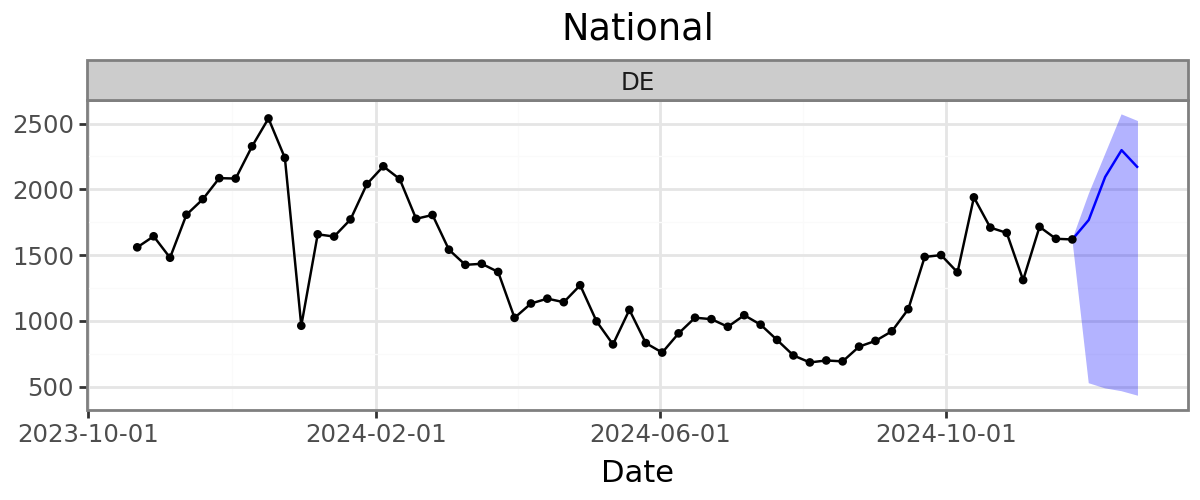

In [25]:
plot_forecasts(df_plot, 'national', start=0)

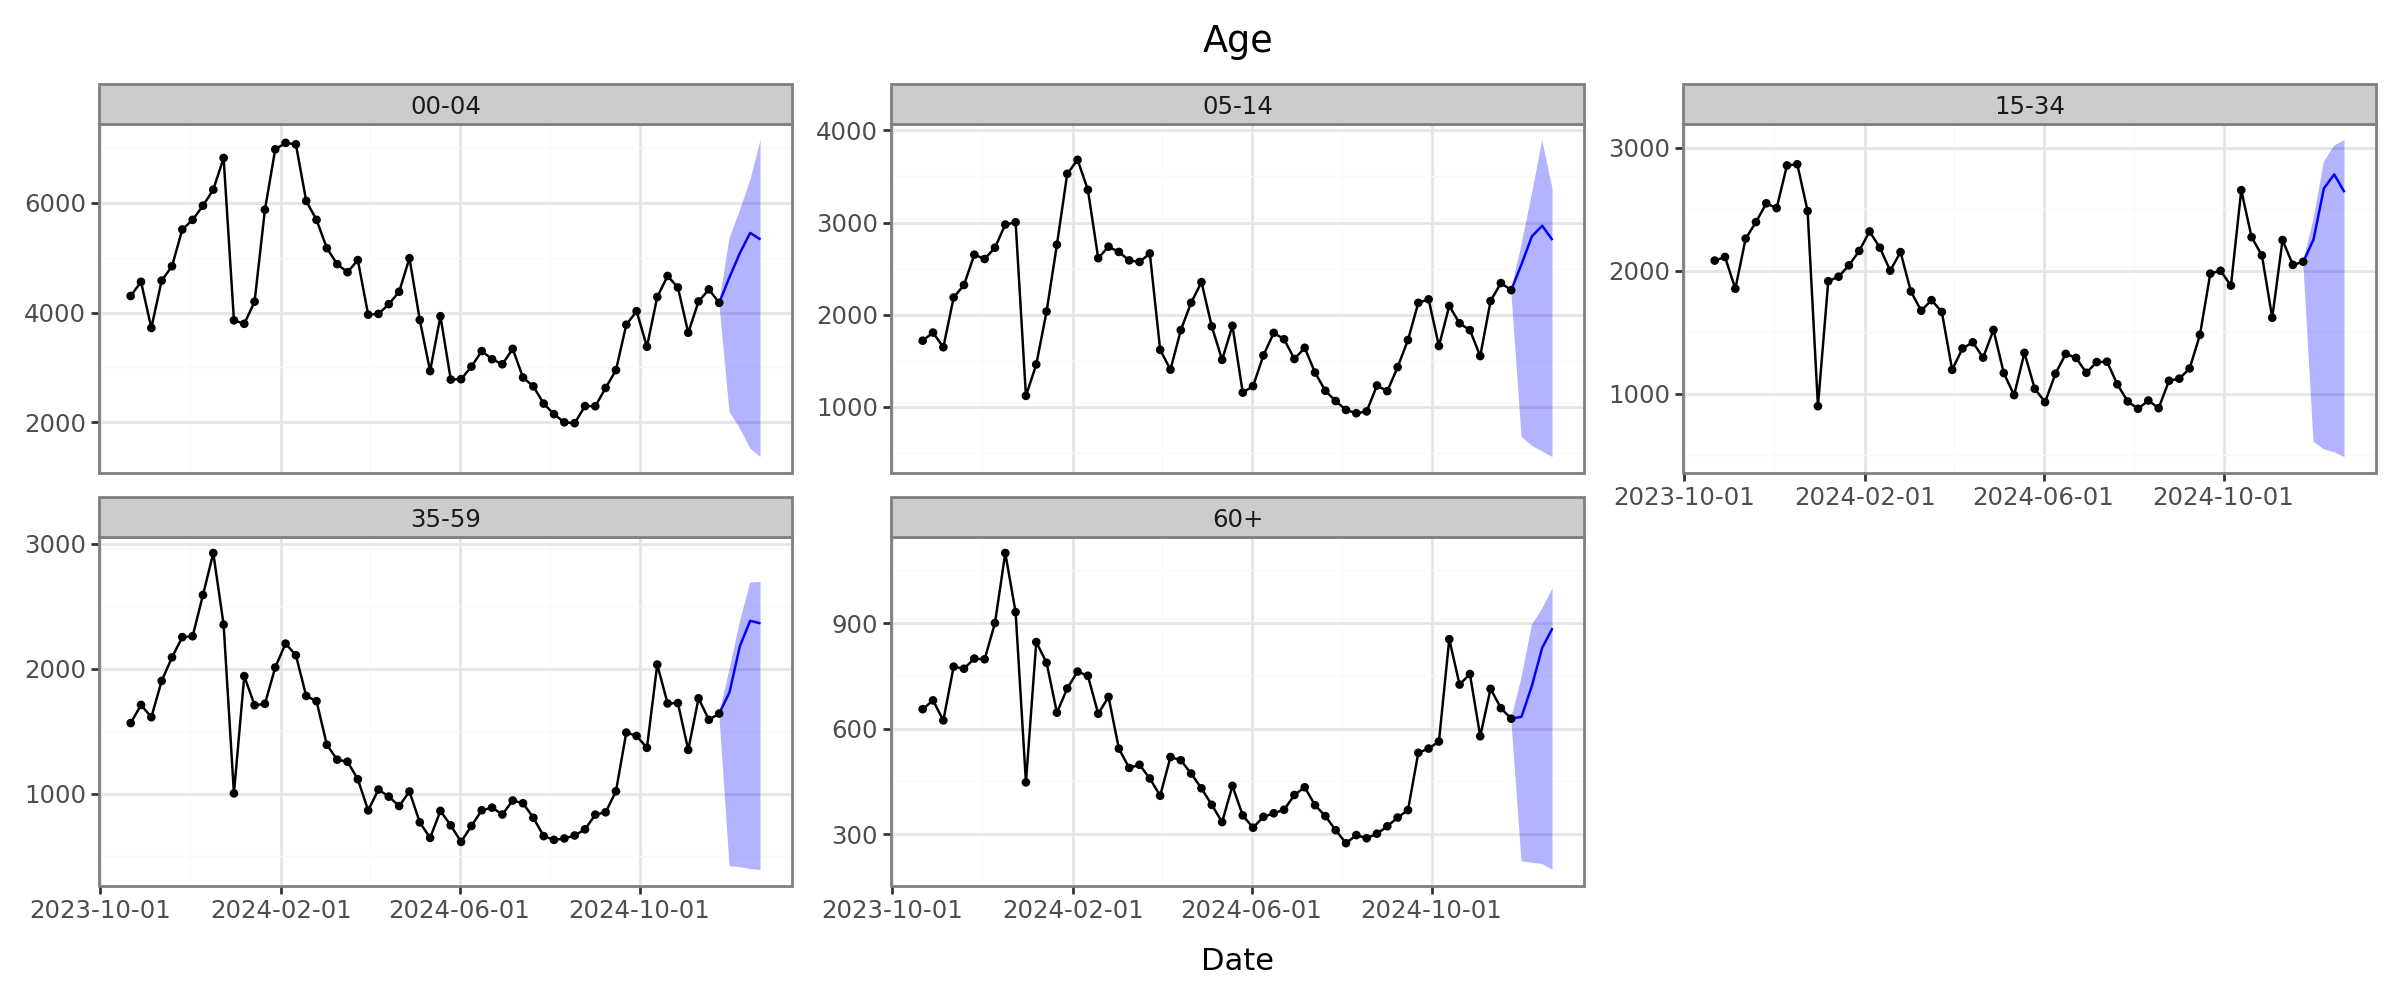

In [26]:
plot_forecasts(df_plot, 'age', start=0)